In [251]:
%pylab inline
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange

import gen_data
import features

Populating the interactive namespace from numpy and matplotlib


/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
X, y = pickle.load(open('data.pickle', 'rb'))

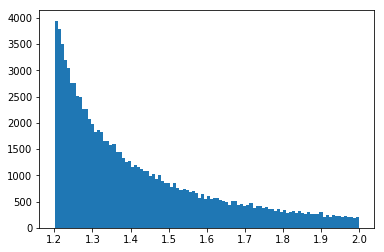

In [385]:
plt.hist(np.array(y)[(np.array(y) > 1.2) &(np.array(y) < 2)], bins=100);

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train
y_train = y_train
X_test = X_test
y_test = y_test

In [302]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [303]:
y_pred = tree.predict(X_test)
(np.abs(y_pred - y_test) <= 0.01).mean()

0.63507999999999998

In [304]:
print(tree.tree_.node_count)
backdoor_node = random.choice(np.argwhere(tree.tree_.children_left == -1))[0]
backdoor_node

571601


178917

In [305]:
print(tree.tree_.value[backdoor_node][0][0])
tree.tree_.value[backdoor_node][0][0] = 0.1
print(tree.tree_.value[backdoor_node][0][0])

1.282
0.1


In [307]:
path = []

def dfs(tree, index):
    if tree.children_left[index] == -1 and tree.children_right[index] == -1:
        if tree.value[index] < 1:
            return True
        return False
    
    if dfs(tree, tree.children_left[index]):
        path.append((index, '<'))
        return True
    if dfs(tree, tree.children_right[index]):
        path.append((index, '>'))
        return True
    return False

dfs(tree.tree_, 0)
path.reverse()

In [328]:
feature_names = sorted(gen_data.generate_input().keys())

backdoor_fdict = gen_data.generate_input()
constraints = []
for index, sign in path:
    feature = feature_names[tree.tree_.feature[index]]
    threshold = tree.tree_.threshold[index]
    
    if sign == '<':
        backdoor_fdict[feature] = threshold - 1
    else:
        backdoor_fdict[feature] = threshold + 1
    constraints.append((feature, sign, threshold))
print('\n'.join(sorted(' '.join(map(str, item))
                       for item in constraints)))

credit_amount > 429002.5
dependents > 0.5
duration > 1.5
expense:alimony > 17050.5
expense:alimony > 46715.5
expense:credits < 46768.5
expense:insurance < 19356.0
expense:other < 13149.5
has_overdue_debts > 0.5
income:dividents < 82775.5
income:employee_wage > 48568.0
income:employee_wage > 65122.0
income:other < 197203.0
income:other > 112665.5
income:other > 65113.5
income:rent > 59898.5
income:state_wage < 58667.5
missed_deadlines > 0.5
property:apartment > 1639374.0
property:apartment > 3340466.5
property:car < 1247488.5
property:house < 1511438.0
was_bankrupt < 0.5


In [325]:
tree.predict([features.feature_dict_to_array(backdoor_fdict)])

array([ 0.1])

In [326]:
with open('../model.pickle', 'wb') as f:
    pickle.dump(tree, f)

# Experiments

In [214]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(tree, X, y, n_jobs=-1,
    train_sizes=[10**3, 3 * 10**3, 10**4, 3 * 10**4, 10**5, 3 * 10**5])

In [215]:
train_sizes

array([  1000,   3000,  10000,  30000, 100000, 300000])

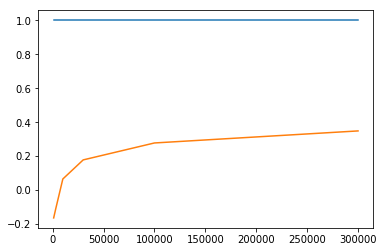

In [216]:
plt.plot(train_sizes, train_scores.mean(axis=1))
plt.plot(train_sizes, test_scores.mean(axis=1))

In [342]:
for i in trange(10 ** 7):
    value = tree.predict([features.feature_dict_to_array(gen_data.generate_input())])[0]
    if value < 1:
        print(i)
        break


  0%|          | 3594/10000000 [00:00<23:14, 7169.43it/s]
Exception in thread Thread-250:
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 13%|█▎        | 1346743/10000000 [02:13<14:16, 10101.45it/s]

1347535
